# Tech Challenge Fase 3 - Grupo 5

## O problema:

Imagine agora que você foi contratado(a) como Expert em Data Analytics por um grande hospital para entender como foi o comportamento da população na época da pandemia da COVID-19 e quais indicadores seriam importantes para o planejamento, caso haja um novo surto da doença.

Apesar de ser contratado(a) agora, a sua área observou que a utilização do estudo do PNAD-COVID 19 do IBGE seria uma ótima base para termos boas respostas ao problema proposto, pois são dados confiáveis. Porém, não será necessário utilizar todas as perguntas realizadas na pesquisa para enxergar todas as oportunidades ali postas.

É sempre bom ressaltar que há dados triviais que precisam estar no projeto, pois auxiliam muito na análise dos dados:


• Características clínicas dos sintomas;

• Características da população;

• Características econômicas da sociedade.

O Head de Dados pediu para que você entrasse na base de dados do PNAD-COVID-19 do IBGE e organizasse esta base para análise, utilizando Banco de Dados em Nuvem e trazendo as seguintes características:

a. Utilização de no máximo 20 questionamentos realizados na pesquisa;

b. Utilizar 3 meses para construção da solução;

c. Caracterização dos sintomas clínicos da população;

d. Comportamento da população na época da COVID-19;

e. Características econômicas da Sociedade.


Seu objetivo será trazer uma breve análise dessas informações, como foi a organização do banco, as perguntas selecionadas para a resposta do problema e quais seriam as principais ações que o hospital deverá tomar em caso de um novo surto de COVID-19.

Dica: leiam com atenção a base de dados e toda a documentação que o site do PNAD – COVID-19 traz, principalmente os dicionários, que ajudam e muito no entendimento da Base de Dados.

Dica 2: utilizem o que já foi ensinado e consolidado nas outras fases para apresentar a resolução do projeto.

## **Criação da Base para Análise**

*Bibliotecas*

In [ ]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=5be63c5ee1ea9a7ed91cfff439d4b3b7a1e291b9c20462b7164430f85f9733ac
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
# Pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#Spark
import findspark
import pyspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import Row, dataframe
from pyspark.sql.types import StructType, StringType,StructField, IntegerType
from pyspark.sql.functions import col, lit,expr,substring,concat,concat_ws,when,coalesce
from pyspark.sql import functions as F #para mais funções sql
from functools import reduce
from pyspark.sql import functions as F
# Drive
import google.colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
spark = SparkSession.builder \
    .appName("pandas-to-spark") \
    .getOrCreate()

In [ ]:
# Leitura de Base
# df5 = spark.read.csv('/content/drive/MyDrive/Pos_tech/Tech_C/Tech_3/Dados/PNAD_COVID_052020.csv', sep=',', inferSchema = True, header = True)

df7 = spark.read.csv('/content/drive/MyDrive/Pos_tech/Tech_C/Tech_3/Dados/PNAD_COVID_072020.csv', sep=',', inferSchema = True, header = True)
df8 = spark.read.csv('/content/drive/MyDrive/Pos_tech/Tech_C/Tech_3/Dados/PNAD_COVID_082020.csv', sep=',', inferSchema = True, header = True)
df9 = spark.read.csv('/content/drive/MyDrive/Pos_tech/Tech_C/Tech_3/Dados/PNAD_COVID_092020.csv', sep=',', inferSchema = True, header = True)


In [ ]:
## Une 3 meses de análise em uma só tabela.

df_total = df7.union(df8)
df_total = df_total.union(df9)

# **1.0 : De Para - Colunas**

In [ ]:
### colunas com  foram utilizadas

colunas = {
    'v1013' : 'mes',
    'UF' : 'estado',
    'v1008': 'domicilio', #int de 1 a 14
    'v1016': 'entrevista_domicilio', #int 1 a 99
    'v1022': 'domicilio_urbano_rural',
    'v1023': 'tipo_area',
    'B0014': 'dificuldade_respiracao',
    'B00111': 'perda_olfato_paladar',
    'B0012': 'tosse',
    'B002': 'estabelecimento_saude', ## Foi a algum estabelecimento?
    'B0042': 'pronto_socorro_pub', ## pronto socorro que buscou atendimento?
    'B0043': 'hospital_sus', ## local que buscou atendimento foi um hospital do sus?
    'B0045': 'pronto_socorro_priv', ## pronto socorro privado ou das forças armadas?
    'B0046': 'hospital_privado', # buscou hospital particular
    'B005': 'internação',
    'B008':'Teste_Covid',
    'B011': 'restricao_contato',
    'C004': 'trabalho_remunerado',
    'B007': 'plano_saude',
    'A002': 'idade',
    'F001': 'situacao_domicilio',
    'B009A': 'exame_swab',
    'B009B': 'resultado_swab',
    'B009C': 'exame_sangue_dedo',
    'B009D': 'resultado_sangue_dedo',
    'B009E': 'exame_sangue_braco',
    'B009F': 'resultado_sangue_braco'
}

In [ ]:
## Renomeia colunas para melhor leitura.
for old_name, new_name in colunas.items():
    df_total = df_total.withColumnRenamed(old_name, new_name)

In [ ]:
# Seleciona colunas que serão analisadas
df_total = df_total.select(['mes','estado','domicilio', 'entrevista_domicilio', 'domicilio_urbano_rural', 'tipo_area', 'projecao_populacao',
                            'dificuldade_respiracao','perda_olfato_paladar', 'tosse', 'estabelecimento_saude', 'restricao_contato',
                            'trabalhou_min_1h', 'afastamento_trabalho','trabalho_remoto', 'trabalho_remunerado', 'plano_saude',
                            'idade', 'situacao_domicilio', 'exame_swab', 'resultado_swab',
                            'exame_sangue_dedo', 'resultado_sangue_dedo', 'exame_sangue_braco', 'resultado_sangue_braco',
                            'pronto_socorro_pub', 'hospital_sus','pronto_socorro_priv','hospital_privado', 'internação',
                            'Teste_Covid'])

# **1.1 De Para - Valores**

In [ ]:
# ## a saida disso vai quer a query do spark pronta iterando sobre todos os itens que tem em no dicionario "colunas"
# ## Usa o dict "colunas" e o dicionario da malu como ferencia

# ### Dicionario da malu abaixo                    TROCAR O CAMINHO PARA EXCUTAR!!
# dicionario = pd.read_csv('/content/drive/MyDrive/Pos_tech/Tech_C/Tech_3/Dados/dicionario.csv', encoding='ISO-8859-1')
# dicionario['nome_coluna'] = dicionario['nome_coluna'].str.upper()

# for pergunta in colunas:
#     valor = dicionario.query('nome_coluna == @pergunta')[['chave','valor']].set_index('chave').to_dict()['valor']
#     query = f"df_total = df_total.withColumn(\n    '{colunas[pergunta]}',\n"
#     for chave, texto in valor.items():
#         query += f"    F.when(df_total['{colunas[pergunta]}'] == {chave}, '{texto}').\n"
#     query += f"    otherwise(df_total['{colunas[pergunta]}'])\n)"
#     print(query)

In [ ]:
df_total = df_total.withColumn(
    'mes',
    F.when(df_total['mes'] == 1, 'Janeiro')
    .when(df_total['mes'] == 2, 'Fevereiro')
    .when(df_total['mes'] == 3, 'Março')
    .when(df_total['mes'] == 4, 'Abril')
    .when(df_total['mes'] == 5, 'Maio')
    .when(df_total['mes'] == 6, 'Junho')
    .when(df_total['mes'] == 7, 'Julho')
    .when(df_total['mes'] == 8, 'Agosto')
    .when(df_total['mes'] == 9, 'Setembro')
    .when(df_total['mes'] == 10, 'Outubro')
    .when(df_total['mes'] == 11, 'Novembro')
    .when(df_total['mes'] == 12, 'Dezembro')
    .otherwise(df_total['mes'])
)

df_total = df_total.withColumn(
    'estado',
    F.when(df_total['estado'] == 11.0, 'Rondônia')
    .when(df_total['estado'] == 12.0, 'Acre')
    .when(df_total['estado'] == 13.0, 'Amazonas')
    .when(df_total['estado'] == 14.0, 'Roraima')
    .when(df_total['estado'] == 15.0, 'Pará')
    .when(df_total['estado'] == 16.0, 'Amapá')
    .when(df_total['estado'] == 17.0, 'Tocantins')
    .when(df_total['estado'] == 21.0, 'Maranhão')
    .when(df_total['estado'] == 22.0, 'Piauí')
    .when(df_total['estado'] == 23.0, 'Ceará')
    .when(df_total['estado'] == 24.0, 'Rio Grande do Norte')
    .when(df_total['estado'] == 25.0, 'Paraíba')
    .when(df_total['estado'] == 26.0, 'Pernambuco')
    .when(df_total['estado'] == 27.0, 'Alagoas')
    .when(df_total['estado'] == 28.0, 'Sergipe')
    .when(df_total['estado'] == 29.0, 'Bahia')
    .when(df_total['estado'] == 31.0, 'Minas Gerais')
    .when(df_total['estado'] == 32.0, 'Espírito Santo')
    .when(df_total['estado'] == 33.0, 'Rio de Janeiro')
    .when(df_total['estado'] == 35.0, 'São Paulo')
    .when(df_total['estado'] == 41.0, 'Paraná')
    .when(df_total['estado'] == 42.0, 'Santa Catarina')
    .when(df_total['estado'] == 43.0, 'Rio Grande do Sul')
    .when(df_total['estado'] == 50.0, 'Mato Grosso do Sul')
    .when(df_total['estado'] == 51.0, 'Mato Grosso')
    .when(df_total['estado'] == 52.0, 'Goiás')
    .when(df_total['estado'] == 53.0, 'Distrito Federal')
    .otherwise(df_total['estado'])
)

df_total = df_total.withColumn(
    'domicilio',
    F.when(df_total['domicilio'].isNull(), df_total['domicilio'])  # Mantém o valor original se não for nulo
    .otherwise(df_total['domicilio'])  # Isso é redundante aqui, pois estamos mantendo o mesmo valor
)

df_total = df_total.withColumn(
    'entrevista_domicilio',
    F.when(df_total['entrevista_domicilio'].isNull(), df_total['entrevista_domicilio'])
    .otherwise(df_total['entrevista_domicilio'])
)

df_total = df_total.withColumn(
    'domicilio_urbano_rural',
    F.when(df_total['domicilio_urbano_rural'].isNull(), df_total['domicilio_urbano_rural'])
    .otherwise(df_total['domicilio_urbano_rural'])
)

df_total = df_total.withColumn(
    'tipo_area',
    F.when(df_total['tipo_area'].isNull(), df_total['tipo_area'])
    .otherwise(df_total['tipo_area'])
)

df_total = df_total.withColumn(
    'projecao_populacao',
    F.when(df_total['projecao_populacao'].isNull(), df_total['projecao_populacao'])
    .otherwise(df_total['projecao_populacao'])
)


df_total = df_total.withColumn(
    'dificuldade_respiracao',
    F.when(df_total['dificuldade_respiracao'] == 3.0, 'Não sabe')
    .when(df_total['dificuldade_respiracao'] == 2.0, 'Não')
    .when(df_total['dificuldade_respiracao'] == 1.0, 'Sim')
    .otherwise(df_total['dificuldade_respiracao'])
)

df_total = df_total.withColumn(
    'perda_olfato_paladar',
    F.when(df_total['perda_olfato_paladar'] == 3.0, 'Não sabe')
    .when(df_total['perda_olfato_paladar'] == 1.0, 'Sim')
    .when(df_total['perda_olfato_paladar'] == 2.0, 'Não')
    .otherwise(df_total['perda_olfato_paladar'])
)

df_total = df_total.withColumn(
    'tosse',
    F.when(df_total['tosse'] == 1.0, 'Sim')
    .when(df_total['tosse'] == 2.0, 'Não')
    .when(df_total['tosse'] == 3.0, 'Não sabe')
    .otherwise(df_total['tosse'])
)

df_total = df_total.withColumn(
    'estabelecimento_saude',
    F.when(df_total['estabelecimento_saude'] == 9.0, 'Ignorado')
    .when(df_total['estabelecimento_saude'].isNull(), 'Não aplicável')
    .when(df_total['estabelecimento_saude'] == 2.0, 'Não')
    .when(df_total['estabelecimento_saude'] == 1.0, 'Sim')
    .otherwise(df_total['estabelecimento_saude'])
)

df_total = df_total.withColumn(
    'restricao_contato',
    F.when(df_total['restricao_contato'] == 3.0, 'Ficou em casa e só saiu em caso de necessidade básica')
    .when(df_total['restricao_contato'] == 9.0, 'Ignorado')
    .when(df_total['restricao_contato'] == 1.0, 'Não fez restrição, levou vida normal como antes da pandemia')
    .when(df_total['restricao_contato'] == 4.0, 'Ficou rigorosamente em casa')
    .when(df_total['restricao_contato'] == 2.0, 'Reduziu o contato com as pessoas, mas continuou saindo de casa para trabalho ou atividades não essenciais e/ou recebendo visitas')
    .otherwise(df_total['restricao_contato'])
)

df_total = df_total.withColumn(
    'trabalhou_min_1h',
    F.when(df_total['trabalhou_min_1h'] == 1.0, 'Sim')
    .when(df_total['trabalhou_min_1h'].isNull(), 'Não aplicável')
    .when(df_total['trabalhou_min_1h'] == 2.0, 'Não')
    .otherwise(df_total['trabalhou_min_1h'])
)

df_total = df_total.withColumn(
    'afastamento_trabalho',
    F.when(df_total['afastamento_trabalho'] == 1.0, 'Sim')
    .when(df_total['afastamento_trabalho'] == 2.0, 'Não')
    .when(df_total['afastamento_trabalho'].isNull(), 'Não aplicável')
    .otherwise(df_total['afastamento_trabalho'])
)

df_total = df_total.withColumn(
    'trabalho_remoto',
    F.when(df_total['trabalho_remoto'].isNull(), 'Não aplicável')
    .when(df_total['trabalho_remoto'] == 2.0, 'Não')
    .when(df_total['trabalho_remoto'] == 1.0, 'Sim')
    .otherwise(df_total['trabalho_remoto'])
)

df_total = df_total.withColumn(
    'trabalho_remunerado',
    F.when(df_total['trabalho_remunerado'] == 2.0, 'Não')
    .when(df_total['trabalho_remunerado'].isNull(), 'Não aplicável')
    .when(df_total['trabalho_remunerado'] == 1.0, 'Sim')
    .when(df_total['trabalho_remunerado'] == 3.0, 'O trabalho já não era remunerado')
    .otherwise(df_total['trabalho_remunerado'])
)

df_total = df_total.withColumn(
    'plano_saude',
    F.when(df_total['plano_saude'] == 9.0, 'Ignorado')
    .when(df_total['plano_saude'] == 2.0, 'Não')
    .when(df_total['plano_saude'] == 1.0, 'Sim')
    .otherwise(df_total['plano_saude'])
)

df_total = df_total.withColumn(
    'idade',
    F.when(df_total['idade'].isNull(), df_total['idade'])  # Exemplo de condição
    .otherwise(df_total['idade'])  # Mantém o mesmo valor se não for nulo
)

df_total = df_total.withColumn(
    'situacao_domicilio',
    F.when(df_total['situacao_domicilio'] == 7.0, 'Outra condição')
    .when(df_total['situacao_domicilio'] == 6.0, 'Cedido de outra forma')
    .when(df_total['situacao_domicilio'] == 5.0, 'Cedido por familiar')
    .when(df_total['situacao_domicilio'] == 4.0, 'Cedido por empregador')
    .when(df_total['situacao_domicilio'] == 1.0, 'Próprio - já pago')
    .when(df_total['situacao_domicilio'] == 2.0, 'Próprio - ainda pagando')
    .when(df_total['situacao_domicilio'] == 3.0, 'Alugado')
    .otherwise(df_total['situacao_domicilio'])
)

df_total = df_total.withColumn(
    'exame_swab',
    F.when(df_total['exame_swab'] == 9.0, 'Ignorado')
    .when(df_total['exame_swab'] == 2.0, 'Não')
    .when(df_total['exame_swab'] == 1.0, 'Sim')
    .otherwise(df_total['exame_swab'])
)

df_total = df_total.withColumn(
    'resultado_swab',
    F.when(df_total['resultado_swab'] == 4.0, 'Ainda não recebeu o resultado')
    .when(df_total['resultado_swab'] == 1.0, 'Positivo')
    .when(df_total['resultado_swab'].isNull(), 'Não aplicável')
    .when(df_total['resultado_swab'] == 2.0, 'Negativo')
    .when(df_total['resultado_swab'] == 9.0, 'Ignorado')
    .when(df_total['resultado_swab'] == 3.0, 'Inconclusivo')
    .otherwise(df_total['resultado_swab'])
)

df_total = df_total.withColumn(
    'exame_sangue_dedo',
    F.when(df_total['exame_sangue_dedo'] == 9.0, 'Ignorado')
    .when(df_total['exame_sangue_dedo'] == 2.0, 'Não')
    .when(df_total['exame_sangue_dedo'] == 1.0, 'Sim')
    .otherwise(df_total['exame_sangue_dedo'])
)

df_total = df_total.withColumn(
    'resultado_sangue_dedo',
    F.when(df_total['resultado_sangue_dedo'] == 9.0, 'Ignorado')
    .when(df_total['resultado_sangue_dedo'].isNull(), 'Não aplicável')
    .when(df_total['resultado_sangue_dedo'] == 3.0, 'Inconclusivo')
    .when(df_total['resultado_sangue_dedo'] == 1.0, 'Positivo')
    .when(df_total['resultado_sangue_dedo'] == 2.0, 'Negativo')
    .when(df_total['resultado_sangue_dedo'] == 4.0, 'Ainda não recebeu o resultado')
    .otherwise(df_total['resultado_sangue_dedo'])
)

df_total = df_total.withColumn(
    'exame_sangue_braco',
    F.when(df_total['exame_sangue_braco'] == 9.0, 'Ignorado')
    .when(df_total['exame_sangue_braco'] == 2.0, 'Não')
    .when(df_total['exame_sangue_braco'] == 1.0, 'Sim')
    .otherwise(df_total['exame_sangue_braco'])
)

df_total = df_total.withColumn(
    'resultado_sangue_braco',
    F.when(df_total['resultado_sangue_braco'] == 4.0, 'Ainda não recebeu o resultado')
    .when(df_total['resultado_sangue_braco'] == 3.0, 'Inconclusivo')
    .when(df_total['resultado_sangue_braco'] == 1.0, 'Positivo')
    .when(df_total['resultado_sangue_braco'] == 2.0, 'Negativo')
    .when(df_total['resultado_sangue_braco'] == 9.0, 'Ignorado')
    .when(df_total['resultado_sangue_braco'].isNull(), 'Não aplicável')
    .otherwise(df_total['resultado_sangue_braco'])
)


df_total = df_total.withColumn(
    'pronto_socorro_pub',
    F.when(df_total['pronto_socorro_pub'] == 9.0, 'Ignorado')
    .when(df_total['pronto_socorro_pub'] == 2.0, 'Não')
    .when(df_total['pronto_socorro_pub'] == 1.0, 'Sim')
    .when(df_total['pronto_socorro_pub'].isNull(), 'Não aplicável')
    .otherwise(df_total['pronto_socorro_pub'])
)

df_total = df_total.withColumn(
    'hospital_sus',
    F.when(df_total['hospital_sus'] == 9.0, 'Ignorado')
    .when(df_total['hospital_sus'] == 2.0, 'Não')
    .when(df_total['hospital_sus'] == 1.0, 'Sim')
    .when(df_total['hospital_sus'].isNull(), 'Não aplicável')
    .otherwise(df_total['hospital_sus'])
)

df_total = df_total.withColumn(
    'pronto_socorro_priv',
    F.when(df_total['pronto_socorro_priv'] == 9.0, 'Ignorado')
    .when(df_total['pronto_socorro_priv'] == 2.0, 'Não')
    .when(df_total['pronto_socorro_priv'] == 1.0, 'Sim')
   .when(df_total['pronto_socorro_priv'].isNull(), 'Não aplicável')
    .otherwise(df_total['pronto_socorro_priv'])
)

df_total = df_total.withColumn(
    'hospital_privado',
    F.when(df_total['hospital_privado'] == 9.0, 'Ignorado')
    .when(df_total['hospital_privado'] == 2.0, 'Não')
    .when(df_total['hospital_privado'] == 1.0, 'Sim')
    .when(df_total['hospital_privado'].isNull(), 'Não aplicável')
    .otherwise(df_total['hospital_privado'])
)

df_total = df_total.withColumn(
    'Teste_Covid',
    F.when(df_total['Teste_Covid'] == 9.0, 'Ignorado')
    .when(df_total['Teste_Covid'] == 2.0, 'Não')
    .when(df_total['Teste_Covid'] == 1.0, 'Sim')
    .when(df_total['Teste_Covid'].isNull(), 'Não aplicável')
    .otherwise(df_total['Teste_Covid'])
)

df_total = df_total.withColumn(
    'internação',
    F.when(df_total['internação'] == 9.0, 'Ignorado')
    .when(df_total['internação'] == 2.0, 'Não')
    .when(df_total['internação'] == 1.0, 'Sim')
  .when(df_total['internação'] == 3.0, 'Não foi atendido')
    .when(df_total['internação'].isNull(), 'Não aplicável')
    .otherwise(df_total['internação'])
)


## **PARTE 0 - CARACTERÍSTICA ECONÔMICA DA SOCIEDADE**

# **Parte 0 -Estado com maior participação nas entrevistas**

In [ ]:
#  Estado com maior participação nas entrevistas - Total de 3 meses de Análise
estado_count = df_total.groupBy('estado').count()

estado_max = estado_count.orderBy(F.desc('count')).first()
estado_max

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Estado com maior participação nas entrevistas por mês (Julho, Agosto, Setembro)


# Agrupar por estado e mês, e contar o número de entrevistas por cada estado em cada mês analisado
estado_mes_count = df_total.groupBy('estado', 'mes').count()

# Para cada mês, encontrar o estado com o maior número de entrevistas
window_spec = Window.partitionBy('mes').orderBy(F.desc('count'))
estado_mes_max = estado_mes_count.withColumn(
    'rank', F.row_number().over(window_spec)
).filter(F.col('rank') == 1)


estado_mes_max.select('mes', 'estado', 'count').show()

+--------+------------+-----+
|     mes|      estado|count|
+--------+------------+-----+
|  Agosto|   São Paulo|    1|
|   Julho|Minas Gerais|    1|
|Setembro|Minas Gerais|    1|
+--------+------------+-----+



# **Parte 0 - Tendo em mente o comando acima, qual a % que vive em zonas urbanas e rurais?**

**Tendo em mente o comando acima, focaremos nossa análise no estado com maior participação na pesquisa do IBGE. **

In [ ]:
## Considerando o Estado de Minas Gerais, qual a participação por região rural/ urbano

df_minas = df_total.filter(F.col('estado') == 'Minas Gerais')

# de para da regiao
df_minas = df_minas.withColumn('mapeamento_area', F.when(F.col('domicilio_urbano_rural') == 1, 'Urbano')
                                             .when(F.col('domicilio_urbano_rural') == 2, 'Rural')
                                             .otherwise('Outros'))

# Contar o número de entrevistas pra cada area
contagem = df_minas.groupBy('mapeamento_area').count()

# Calcular o total de registros em Minas Gerais

total_minas = df_minas.count()

# Calcular a porcentagem de cada tipo de área
participação = contagem.withColumn('percentual', F.round((F.col('count') / total_minas) * 100, 2))
participação.show()

+---------------+-----+----------+
|mapeamento_area|count|percentual|
+---------------+-----+----------+
|         Urbano|76676|     73.62|
|          Rural|27480|     26.38|
+---------------+-----+----------+



In [ ]:
# Instalar bibliotecas necessárias
!pip install matplotlib pandas

# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

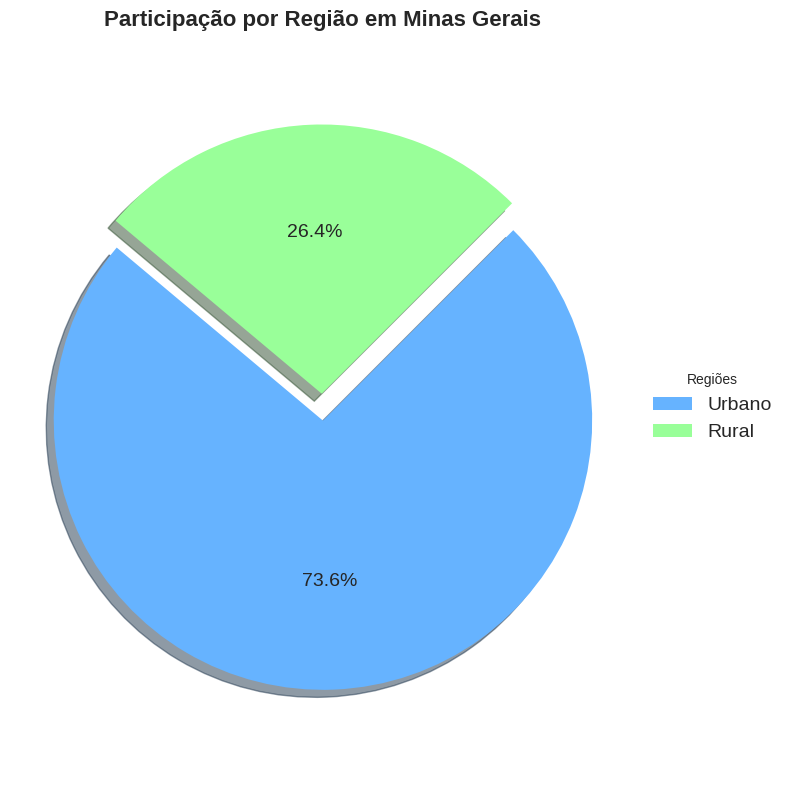

In [ ]:
data = {
    'mapeamento_area': ['Urbano', 'Rural'],
    'count': [76676, 27480]
}
participação = pd.DataFrame(data)

# Calcular a porcentagem de cada tipo de área
total_minas = participação['count'].sum()
participação['percentual'] = (participação['count'] / total_minas) * 100

# Cores personalizadas
cores = ['#66b3ff', '#99ff99']

# Explosão de fatias
explode = (0.05, 0.05)  # Pequena separação das fatias

# Criar o gráfico de pizza
plt.figure(figsize=(8, 8))

# Criar gráfico de pizza sem legenda
wedges, texts, autotexts = plt.pie(participação['percentual'], autopct='%1.1f%%', startangle=140,
                                   colors=cores, explode=explode, shadow=True, textprops={'fontsize': 14})

# Título
plt.title('Participação por Região em Minas Gerais', fontsize=16, weight='bold')

# Colocar legenda fora do gráfico
plt.legend(wedges, participação['mapeamento_area'], title="Regiões", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=14)

# Garantir que o gráfico seja circular
plt.axis('equal')

# Mostrar o gráfico
plt.tight_layout()  # Para ajustar a posição dos elementos
plt.show()


--- *Focaremos nossa análise na Zona Urbana*

# **Parte 0 - Plano de Saúde**

In [ ]:
# Filtra pessoas que vivem em zonas urbanas
df_urbano = df_minas.filter(F.col('mapeamento_area') == 'Urbano')

# Filtra as pessoas que têm plano de saúde
df_urbano_com_plano = df_urbano.filter(F.col('plano_saude') == 'Sim')

# Conta o total de pessoas em zonas urbanas
total_urbano_plano = df_urbano.count()

# Conta as pessoas que têm plano de saúde
total_urbano_com_plano = df_urbano_com_plano.count()

# Calcula a %
if total_urbano_plano > 0:
    tem_plano = (total_urbano_com_plano / total_urbano_plano) * 100
else:
    tem_plano = 0

print(f"Porcentagem (%) de pessoas que vivem em zona Urbana e têm plano de saúde: {tem_plano:.2f}%")

Porcentagem (%) de pessoas que vivem em zona Urbana e têm plano de saúde: 34.15%


# **Parte 0 - Situação Domiciliar da Zona Urbana**

In [ ]:
# Agrupa por situacao_domicilio e contar o número de pessoas em cada grupo
df_urbano_casas = df_urbano.groupBy('situacao_domicilio').agg(F.count('*').alias('total_por_situacao'))

total_urbano = df_urbano.count()

# Calcular a %
df_part = df_urbano_casas.withColumn(
    'percentual',
    F.format_number((F.col('total_por_situacao') / total_urbano) * 100, 2))

df_part = df_part.orderBy(F.col('percentual').desc())
df_part.show(truncate=False)

+-----------------------+------------------+----------+
|situacao_domicilio     |total_por_situacao|percentual|
+-----------------------+------------------+----------+
|Próprio - ainda pagando|6329              |8.25      |
|Próprio - já pago      |47214             |61.58     |
|Alugado                |14227             |18.55     |
|Cedido por familiar    |8085              |10.54     |
|Cedido de outra forma  |505               |0.66      |
|Cedido por empregador  |208               |0.27      |
|Outra condição         |108               |0.14      |
+-----------------------+------------------+----------+



# **Parte 0 - Trabalho Remunerado e Média de Idade por situação salarial**

In [ ]:
# Agrupa por remuneração salarial (trabalho_remunerado) e média de idade pra casa situação
df_urbano_trab = df_urbano.groupBy('trabalho_remunerado').agg(
    F.count('*').alias('total_por_situacao'),
     F.round(F.avg('idade'), 0).alias('media_idade')
)

# Conta pessoas
total_urbano = df_urbano.count()

# Calcula a %
df_part = df_urbano_trab.withColumn(
    'percentual',
    F.format_number((F.col('total_por_situacao') / total_urbano) * 100, 2))

df_part = df_part.orderBy(F.col('percentual').desc())
df_part.show(truncate=False)

## **PARTE 1 - COMPORTAMENTO DA SOCIEDADE NO COVID-19 (No período de 3 meses)**

# **Parte 1 - Procuraram um Sistema de Saúde?**

PROCURA DA POPULAÇÃO PELO SISTEMA PÚBLICO

In [ ]:
# Filtra as pessoas que procuraram sistema publico
df_urbano_publico = df_urbano.filter(
    (F.col('pronto_socorro_pub') == 'Sim') | (F.col('hospital_sus') == 'Sim'))

# Conta o total de pessoas em zonas urbanas por mês
total_urbano_por_mes = df_urbano.groupBy('mes').count().withColumnRenamed('count', 'total_urbano')

# Conta o total de pessoas que procuraram o sistema público em zonas urbanas por mês
total_urbano_pub_por_mes = df_urbano_publico.groupBy('mes').count().withColumnRenamed('count', 'total_publico')

# Junta as duas contagens para calcular a % por mês
df_resultado = total_urbano_pub_por_mes.join(total_urbano_por_mes, 'mes')

# Calculaa a %
df_resultado = df_resultado.withColumn(
    'percentual_publico', F.round((F.col('total_publico') / F.col('total_urbano')) * 100, 2))

df_resultado.select('mes', 'total_urbano', 'total_publico', 'percentual_publico').show()

In [ ]:
#  Filtra as pessoas que procuraram o sistema privado
df_urbano_privado = df_urbano.filter(
    (F.col('pronto_socorro_priv') == 'Sim') | (F.col('hospital_privado') == 'Sim'))

# Conta o total de pessoas que procuraram o sistema privado em zonas urbanas por mês
total_urbano_priv_por_mes = df_urbano_privado.groupBy('mes').count().withColumnRenamed('count', 'total_privado')

df_resultado = total_urbano_priv_por_mes.join(total_urbano_por_mes, 'mes')

# Calcula a %
df_resultado = df_resultado.withColumn(
    'percentual_privado', F.round((F.col('total_privado') / F.col('total_urbano')) * 100, 2))

df_resultado.select('mes', 'total_urbano', 'total_privado', 'percentual_privado').show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtra as pessoas que procuraram sistema público
df_urbano_publico = df_urbano.filter(
    (F.col('pronto_socorro_pub') == 'Sim') | (F.col('hospital_sus') == 'Sim'))

# Conta o total de pessoas em zonas urbanas por mês
total_urbano_por_mes = df_urbano.groupBy('mes').count().withColumnRenamed('count', 'total_urbano')

# Conta o total de pessoas que procuraram o sistema público em zonas urbanas por mês
total_urbano_pub_por_mes = df_urbano_publico.groupBy('mes').count().withColumnRenamed('count', 'total_publico')

# Junta as duas contagens para calcular a % por mês
df_resultado_pub = total_urbano_pub_por_mes.join(total_urbano_por_mes, 'mes')

# Calcula a % para o público
df_resultado_pub = df_resultado_pub.withColumn(
    'percentual_publico', F.round((F.col('total_publico') / F.col('total_urbano')) * 100, 2)
)

# Filtra as pessoas que procuraram o sistema privado
df_urbano_privado = df_urbano.filter(
    (F.col('pronto_socorro_priv') == 'Sim') | (F.col('hospital_privado') == 'Sim'))

# Conta o total de pessoas que procuraram o sistema privado em zonas urbanas por mês
total_urbano_priv_por_mes = df_urbano_privado.groupBy('mes').count().withColumnRenamed('count', 'total_privado')

# Junta as duas contagens para calcular a % por mês
df_resultado_priv = total_urbano_priv_por_mes.join(total_urbano_por_mes, 'mes')

# Calcula a % para o privado
df_resultado_priv = df_resultado_priv.withColumn(
    'percentual_privado', F.round((F.col('total_privado') / F.col('total_urbano')) * 100, 2)
)

# Juntando os resultados para comparação
df_comparativo = df_resultado_pub.join(df_resultado_priv, 'mes')\
    .select('mes', 'percentual_publico', 'percentual_privado')

# Coletar os resultados em um DataFrame Pandas
df_comparativo_pd = df_comparativo.toPandas()

# Configurar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_comparativo_pd['mes'], df_comparativo_pd['percentual_publico'], marker='o', label='Sistema Público', color='blue')
plt.plot(df_comparativo_pd['mes'], df_comparativo_pd['percentual_privado'], marker='o', label='Sistema Privado', color='orange')

# Adicionar título e rótulos
plt.title('Comparação entre Sistemas Público e Privado em Zonas Urbanas por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Tipo de Sistema')
plt.grid()

# Adicionar rótulos nos pontos
for i in range(len(df_comparativo_pd)):
    plt.text(df_comparativo_pd['mes'][i], df_comparativo_pd['percentual_publico'][i] + 1,
             f"{df_comparativo_pd['percentual_publico'][i]}%",
             horizontalalignment='center', color='blue', fontsize=10)

    plt.text(df_comparativo_pd['mes'][i], df_comparativo_pd['percentual_privado'][i] + 1,
             f"{df_comparativo_pd['percentual_privado'][i]}%",
             horizontalalignment='center', color='orange', fontsize=10)

# Ajustar o layout do gráfico
plt.tight_layout()

# Mostrar o gráfico
plt.show()


# ***Calculamos a procura do Sistema de Saúde somando as procuras por público e privado pra ter mais sensibilidade.  ***

In [ ]:
total_urbano_pub_por_mes = df_urbano_publico.groupBy('mes').count().withColumnRenamed('count', 'total_publico')
total_urbano_priv_por_mes = df_urbano_privado.groupBy('mes').count().withColumnRenamed('count', 'total_privado')

df_resultado = total_urbano_pub_por_mes.join(total_urbano_priv_por_mes, 'mes')

df_resultado = df_resultado.withColumn('total_publico_privado', F.col('total_publico') + F.col('total_privado'))


df_resultado = df_resultado.withColumn(
    'percentual_publico', F.round((F.col('total_publico') / F.col('total_publico_privado')) * 100, 2))


df_resultado = df_resultado.withColumnRenamed('mes', 'Mês') \
                           .withColumnRenamed('total_publico', 'Buscaram Hosp Público') \
                           .withColumnRenamed('total_privado', 'Buscaram Hosp Privado') \
                           .withColumnRenamed('total_publico_privado', 'Busca Total') \
                           .withColumnRenamed('percentual_publico', '% de Busca')

df_resultado.select(F.col('Mês'),F.col('Buscaram Hosp Público'),F.col('Buscaram Hosp Privado'),F.col('Busca Total'),F.col('% de Busca')).show()

# **Parte 1 - Realizou teste do Covid? Qual?**

In [ ]:
from pyspark.sql import functions as F

# Filtrar as pessoas que procuraram atendimento e fizeram teste de COVID (sistema público ou privado)
df_teste_covid_publico = df_urbano_publico.filter(F.col('Teste_Covid') == 'Sim')
df_teste_covid_privado = df_urbano_privado.filter(F.col('Teste_Covid') == 'Sim')
teste_covid = df_teste_covid_publico.union(df_teste_covid_privado)

# Conta o total de pessoas que fizeram o teste de COVID-19 por mês
total_teste_covid_por_mes = teste_covid.groupBy('mes').count().withColumnRenamed('count', 'total_teste_covid')

# Calcula totais e percentuais para cada tipo de teste
def calcular_percentuais(df):
    total = df.count()
    percentuais = {
        'percentual_swab': round((df.filter(F.col('exame_swab') == 'Sim').count() / total * 100), 2) if total > 0 else 0,
        'percentual_dedo': round((df.filter(F.col('exame_sangue_dedo') == 'Sim').count() / total * 100), 2) if total > 0 else 0,
        'percentual_sangue_braco': round((df.filter(F.col('exame_sangue_braco') == 'Sim').count() / total * 100), 2) if total > 0 else 0}
    return percentuais

# Aplica a função de percentuais e criar um DataFrame de resultados
resultados = []
for row in total_teste_covid_por_mes.collect():
    mes = row['mes']
    count_teste = row['total_teste_covid']
    teste_covid_mes = teste_covid.filter(F.col('mes') == mes)

    percentuais = calcular_percentuais(teste_covid_mes)
    resultados.append((mes, count_teste, percentuais['percentual_swab'], percentuais['percentual_dedo'], percentuais['percentual_sangue_braco']))

df_resultado = spark.createDataFrame(resultados, schema=['Mês', 'Total Testes COVID', 'Porcentagem SWAB', 'Porcentagem Dedo', 'Porcentagem Sangue no Braço'])

df_resultado.show()


In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Filtrar as pessoas que procuraram atendimento e fizeram teste de COVID (sistema público ou privado)
df_teste_covid_publico = df_urbano_publico.filter(F.col('Teste_Covid') == 'Sim')
df_teste_covid_privado = df_urbano_privado.filter(F.col('Teste_Covid') == 'Sim')
teste_covid = df_teste_covid_publico.union(df_teste_covid_privado)

# Conta o total de pessoas que fizeram o teste de COVID-19 por mês
total_teste_covid_por_mes = teste_covid.groupBy('mes').count().withColumnRenamed('count', 'total_teste_covid')

# Calcula totais e percentuais para cada tipo de teste
def calcular_percentuais(df):
    total = df.count()
    percentuais = {
        'percentual_swab': round((df.filter(F.col('exame_swab') == 'Sim').count() / total * 100), 2) if total > 0 else 0,
        'percentual_dedo': round((df.filter(F.col('exame_sangue_dedo') == 'Sim').count() / total * 100), 2) if total > 0 else 0,
        'percentual_sangue_braco': round((df.filter(F.col('exame_sangue_braco') == 'Sim').count() / total * 100), 2) if total > 0 else 0}
    return percentuais

# Aplica a função de percentuais e criar um DataFrame de resultados
resultados = []
for row in total_teste_covid_por_mes.collect():
    mes = row['mes']
    count_teste = row['total_teste_covid']
    teste_covid_mes = teste_covid.filter(F.col('mes') == mes)

    percentuais = calcular_percentuais(teste_covid_mes)
    resultados.append((mes, count_teste, percentuais['percentual_swab'], percentuais['percentual_dedo'], percentuais['percentual_sangue_braco']))

df_resultado = spark.createDataFrame(resultados, schema=['Mês', 'Total Testes COVID', 'Porcentagem SWAB', 'Porcentagem Dedo', 'Porcentagem Sangue no Braço'])

# Coletar os resultados em um DataFrame Pandas
df_resultado_pd = df_resultado.toPandas()

# Configurar o gráfico
plt.figure(figsize=(10, 6))
bar_width = 0.2  # Largura das barras
x = range(len(df_resultado_pd['Mês']))

# Criar barras para cada tipo de teste
plt.bar([i - bar_width for i in x], df_resultado_pd['Porcentagem SWAB'], width=bar_width, label='SWAB', color='blue')
plt.bar(x, df_resultado_pd['Porcentagem Dedo'], width=bar_width, label='Dedo', color='orange')
plt.bar([i + bar_width for i in x], df_resultado_pd['Porcentagem Sangue no Braço'], width=bar_width, label='Sangue no Braço', color='green')

# Adicionar título e rótulos
plt.title('Porcentagem de Testes de COVID-19 por Tipo e Mês', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xticks(x, df_resultado_pd['Mês'], rotation=45)
plt.legend(title='Tipo de Teste')
plt.grid(axis='y')

# Adicionar rótulos nas barras
for i in range(len(df_resultado_pd)):
    plt.text(i - bar_width, df_resultado_pd['Porcentagem SWAB'][i] + 1,
             f"{df_resultado_pd['Porcentagem SWAB'][i]}%",
             horizontalalignment='center', color='blue')

    plt.text(i, df_resultado_pd['Porcentagem Dedo'][i] + 1,
             f"{df_resultado_pd['Porcentagem Dedo'][i]}%",
             horizontalalignment='center', color='orange')

    plt.text(i + bar_width, df_resultado_pd['Porcentagem Sangue no Braço'][i] + 1,
             f"{df_resultado_pd['Porcentagem Sangue no Braço'][i]}%",
             horizontalalignment='center', color='green')

# Mostrar o gráfico
plt.tight_layout()
plt.show()


# **Parte 1 - Realizou teste do COVID em casa?**

### **Tendo em vista que os exames SWAB podem ser feitos pelo própria pessoa e não necessitando de uma ida aos postos de saúde, analisaremos: **

In [ ]:
from pyspark.sql import functions as F


### Filtra quem não foi ao hospital
df_urbano_publico2 = df_urbano.filter(
    (F.col('pronto_socorro_pub') == 'Não') | (F.col('hospital_sus') == 'Não'))
df_urbano_privado2 = df_urbano.filter(
    (F.col('pronto_socorro_priv') == 'Não') | (F.col('hospital_privado') == 'Não'))

# Filtrar as pessoas fizeram teste de COVID - SWAB sem ir ao atendimento especializado:
df_teste_covid_publico = df_urbano_publico2.filter(F.col('Teste_Covid') == 'Sim')
df_teste_covid_privado = df_urbano_privado2.filter(F.col('Teste_Covid') == 'Sim')
teste_covid = df_teste_covid_publico.union(df_teste_covid_privado)

# Conta o total de pessoas que fizeram o teste de COVID-19 por mês
total_teste_covid_por_mes = teste_covid.groupBy('mes').count().withColumnRenamed('count', 'total_teste_covid')

# Calcula totais e percentuais para EXAMES SWAB:::
def calcular_percentuais(df):
    total = df.count()
    percentuais = {
        'percentual_swab': round((df.filter(F.col('exame_swab') == 'Sim').count() / total * 100), 2) if total > 0 else 0}
    return percentuais

# Aplica a função de percentuais e criar um DataFrame de resultados
resultados = []
for row in total_teste_covid_por_mes.collect():
    mes = row['mes']
    count_teste = row['total_teste_covid']
    teste_covid_mes = teste_covid.filter(F.col('mes') == mes)

    percentuais = calcular_percentuais(teste_covid_mes)
    resultados.append((mes, count_teste, percentuais['percentual_swab']))

df_resultado = spark.createDataFrame(resultados, schema=['Mês', 'Total Testes COVID', 'Porcentagem SWAB'])
df_resultado.show()

# **Parte 1 - Isolamento**

In [ ]:

# Agrupaa por restricao_contato e contar o número de pessoas em cada grupo
df_urbano_restricao = df_urbano.groupBy('restricao_contato').agg(F.count('*').alias('total_por_restricao'))

# Conta o total de pessoas em zonas urbanas
total_urbano = df_urbano.count()

df_percentuais = df_urbano_restricao.withColumn('percentual',
    F.format_number((F.col('total_por_restricao') / total_urbano) * 100, 2))

df_percentuais = df_percentuais.orderBy(F.col('percentual').desc())
df_percentuais.show(truncate=False)

## **PARTE 2 - SINTOMAS CLÍNICOS**

# **Parte 2 - Resultados dos testes de COVID-19**

In [ ]:
# Definir o total de testes COVID, agrupando por mês
total_teste_covid_por_mes = teste_covid.groupBy('mes').count().withColumnRenamed('count', 'total_teste_covid')

# Conta o total de pessoas que tiveram resultado positivo para cada tipo de teste, por mês
total_swab_positivo_por_mes = teste_covid.filter((F.col('exame_swab') == 'Sim') &
                                                 (F.col('resultado_swab') == 'Positivo')
                                                ).groupBy('mes').count().withColumnRenamed('count', 'total_swab_positivo')

total_dedo_positivo_por_mes = teste_covid.filter((F.col('exame_sangue_dedo') == 'Sim') &
                                                 (F.col('resultado_sangue_dedo') == 'Positivo')
                                                ).groupBy('mes').count().withColumnRenamed('count', 'total_dedo_positivo')

total_sangue_braco_positivo_por_mes = teste_covid.filter((F.col('exame_sangue_braco') == 'Sim') &
                                                         (F.col('resultado_sangue_braco') == 'Positivo')
                                                        ).groupBy('mes').count().withColumnRenamed('count', 'total_sangue_braco_positivo')

# Juntar os resultados de testes positivos com o total de testes COVID por mês
df_resultado = total_teste_covid_por_mes \
                                      .join(total_swab_positivo_por_mes, 'mes', 'left') \
                                      .join(total_dedo_positivo_por_mes, 'mes', 'left') \
                                      .join(total_sangue_braco_positivo_por_mes, 'mes', 'left')

# Calcula os percentuais de resultados positivos para cada tipo de teste
df_resultado = df_resultado.withColumn(
                                 'percentual_swab_positivo', F.round((F.col('total_swab_positivo') / F.col('total_teste_covid')) * 100, 2)
                             ).withColumn(
                                 'percentual_dedo_positivo', F.round((F.col('total_dedo_positivo') / F.col('total_teste_covid')) * 100, 2)
                             ).withColumn(
                                 'percentual_sangue_braco_positivo', F.round((F.col('total_sangue_braco_positivo') / F.col('total_teste_covid')) * 100, 2))


df_resultado.select('mes', 'percentual_swab_positivo', 'percentual_dedo_positivo', 'percentual_sangue_braco_positivo').show(truncate=False)

# **Parte 2 - Resultado COVID de acordo com comportamento:**

In [ ]:
teste_covid_realizado = teste_covid.filter(
    (F.col('exame_swab') == 'Sim') |
    (F.col('exame_sangue_dedo') == 'Sim') |
    (F.col('exame_sangue_braco') == 'Sim')
)

# Agrupar por restricao_contato
df_restricao_positivo = teste_covid_realizado.groupBy('restricao_contato').agg(F.count('*').alias('total_por_restricao'))

# Contar o total de pessoas que realizaram teste
total_realizado = teste_covid_realizado.count()

# Calcular o percentual para cada restrição de contato
df_percentuais_exames = df_restricao_positivo.withColumn('percentual',
    F.format_number((F.col('total_por_restricao') / total_realizado) * 100, 2))

df_percentuais_exames = df_percentuais_exames.orderBy(F.col('percentual').desc())
df_percentuais_exames.show(truncate=False)

In [ ]:
teste_covid_positivo = teste_covid.filter(
    (F.col('resultado_swab') == 'Positivo') |
    (F.col('resultado_sangue_dedo') == 'Positivo') |
    (F.col('resultado_sangue_braco') == 'Positivo')
)

# Agrupar por restricao_contato
df_restricao_positivo = teste_covid_positivo.groupBy('restricao_contato').agg(F.count('*').alias('total_por_restricao'))

# Contar o total de pessoas que testaram positivo
total_positivo = teste_covid_positivo.count()

# Calcular o percentual para cada restrição de contato
df_percentuais_positivo = df_restricao_positivo.withColumn('percentual',
    F.format_number((F.col('total_por_restricao') / total_positivo) * 100, 2))

df_percentuais_positivo = df_percentuais_positivo.orderBy(F.col('percentual').desc())
df_percentuais_positivo.show(truncate=False)

# **Parte 2 - Sintomas Clinicos de quem testou positivo**

In [ ]:
from pyspark.sql import functions as F

# Agrupa por mês e calcular o total de pessoas que fizeram teste de COVID
total_teste_covid_por_mes = teste_covid.groupBy('mes').count().withColumnRenamed('count', 'total_teste_covid')

# Conta o total de pessoas que tiveram resultado positivo para cada tipo de teste por mês
total_swab_positivo_por_mes = teste_covid.filter(
    (F.col('exame_swab') == 'Sim') & (F.col('resultado_swab') == 'Positivo')
).groupBy('mes').count().withColumnRenamed('count', 'total_swab_positivo')

total_dedo_positivo_por_mes = teste_covid.filter(
    (F.col('exame_sangue_dedo') == 'Sim') & (F.col('resultado_sangue_dedo') == 'Positivo')
).groupBy('mes').count().withColumnRenamed('count', 'total_dedo_positivo')

total_sangue_braco_positivo_por_mes = teste_covid.filter(
    (F.col('exame_sangue_braco') == 'Sim') & (F.col('resultado_sangue_braco') == 'Positivo')
).groupBy('mes').count().withColumnRenamed('count', 'total_sangue_braco_positivo')

# Junta os resultados com o total de testes por mês
df_resultado = total_teste_covid_por_mes \
    .join(total_swab_positivo_por_mes, 'mes', 'left') \
    .join(total_dedo_positivo_por_mes, 'mes', 'left') \
    .join(total_sangue_braco_positivo_por_mes, 'mes', 'left')

# Calcula os percentuais de resultados positivos para cada tipo de teste
df_resultado = df_resultado.withColumn(
                                'percentual_swab_positivo', F.round((F.col('total_swab_positivo') / F.col('total_teste_covid')) * 100, 2)
                            ).withColumn(
                                'percentual_dedo_positivo', F.round((F.col('total_dedo_positivo') / F.col('total_teste_covid')) * 100, 2)
                            ).withColumn(
                                'percentual_sangue_braco_positivo', F.round((F.col('total_sangue_braco_positivo') / F.col('total_teste_covid')) * 100, 2))

df_resultado.select('mes', 'percentual_swab_positivo', 'percentual_dedo_positivo', 'percentual_sangue_braco_positivo').show(truncate=False)

# **Parte 2 - Sintomas por Tipo de Teste**

In [ ]:
resultados_mensais = {}

# Para cada tipo de teste
for tipo_teste, coluna_exame, coluna_resultado in [
    ('SWAB', 'exame_swab', 'resultado_swab'),
    ('Exame de Sangue Dedo', 'exame_sangue_dedo', 'resultado_sangue_dedo'),
    ('Exame de Sangue Padrão', 'exame_sangue_braco', 'resultado_sangue_braco'),
]:
    # Filtra para quem teve resultado positivo para o teste
    teste_positivo = teste_covid.filter((F.col(coluna_exame) == 'Sim') & (F.col(coluna_resultado) == 'Positivo'))

    # Agrupa por mês e calcula os totais
    total_por_mes = teste_positivo.groupBy('mes').count().withColumnRenamed('count', 'total_positivo')

    # Para cada mês calcula os sintomas
    for row in total_por_mes.collect():
        mes = row['mes']
        total_positivo = row['total_positivo']

        teste_positivo_mes = teste_positivo.filter(F.col('mes') == mes)

        if total_positivo > 0:
            total_perda_olfato = teste_positivo_mes.filter(F.col('perda_olfato_paladar') == 'Sim').count()
            percentual_perda_olfato = (total_perda_olfato / total_positivo) * 100

            total_dificuldade_respiracao = teste_positivo_mes.filter(F.col('dificuldade_respiracao') == 'Sim').count()
            percentual_dificuldade_respiracao = (total_dificuldade_respiracao / total_positivo) * 100

            total_tosse = teste_positivo_mes.filter(F.col('tosse') == 'Sim').count()
            percentual_tosse = (total_tosse / total_positivo) * 100
        else:
            percentual_perda_olfato = 0
            percentual_dificuldade_respiracao = 0
            percentual_tosse = 0

        if mes not in resultados_mensais:
            resultados_mensais[mes] = {}

        resultados_mensais[mes][tipo_teste] = {
            'percentual_perda_olfato': percentual_perda_olfato,
            'percentual_dificuldade_respiracao': percentual_dificuldade_respiracao,
            'percentual_tosse': percentual_tosse
        }

for mes, resultados_mes in resultados_mensais.items():
    print(f"Resultados para o mês {mes}:")
    for tipo_teste, percentuais in resultados_mes.items():
        print(f"Teste {tipo_teste}:")
        print(f" % com perda de olfato/paladar: {percentuais['percentual_perda_olfato']:.2f}%")
        print(f" % com dificuldade de respiração: {percentuais['percentual_dificuldade_respiracao']:.2f}%")
        print(f" % com tosse: {percentuais['percentual_tosse']:.2f}%")

# **Parte 2 - Internação dos casos Positivos**

In [ ]:
resultados_internamento = {}

# Para cada tipo de teste
for tipo_teste, coluna_exame, coluna_resultado in [
    ('SWAB', 'exame_swab', 'resultado_swab'),
    ('Exame de Sangue Dedo', 'exame_sangue_dedo', 'resultado_sangue_dedo'),
    ('Exame de Sangue Padrão', 'exame_sangue_braco', 'resultado_sangue_braco'),
]:

    teste_positivo = teste_covid.filter((F.col(coluna_exame) == 'Sim') & (F.col(coluna_resultado) == 'Positivo'))
    total_positivo = teste_positivo.count()

    total_internados = teste_positivo.filter(F.col('internação') == 'Sim').count()

    if total_positivo > 0:
        percentual_internados = (total_internados / total_positivo) * 100
    else:
        percentual_internados = 0

    resultados_internamento[tipo_teste] = percentual_internados

for tipo_teste, percentual in resultados_internamento.items():
    print(f"% de quem ficou internado com COVID-19 realizando o teste: {tipo_teste}: {percentual:.2f}%")

In [ ]:
total_internados = teste_positivo.filter(F.col('internação') == 'Sim').count()
total_positivo = teste_positivo.count()
percentual_internados = (total_internados / total_positivo) * 100 if total_positivo > 0 else 0
print(f"% de internados com casos positivos: {percentual_internados:.2f}%")

# **Parte 2 - Média de Idade por Internação**

In [ ]:
internados_idade = teste_positivo.filter(F.col('internação') == 'Sim')
media_idade = internados_idade.agg(
    F.round(F.avg(F.when(F.col('exame_swab') == 'Sim', F.col('idade'))), 0).alias('Média de Idade (SWAB)'),
    F.round(F.avg(F.when(F.col('exame_sangue_dedo') == 'Sim', F.col('idade'))), 0).alias('Média de Idade (Exame de Dedo)'),
    F.round(F.avg(F.when(F.col('exame_sangue_braco') == 'Sim', F.col('idade'))), 0).alias('Média de Idade (Exame de Sangue Padrão)'))

media_idade.show()

In [ ]:
import matplotlib.pyplot as plt
!pip install pyspark
import pyspark.sql.functions as F

# Calcular a média de idade dos internados por tipo de exame
media_idade = internados_idade.agg(
    F.round(F.avg(F.when(F.col('exame_swab') == 'Sim', F.col('idade'))), 0).alias('Média de Idade (SWAB)'),
    F.round(F.avg(F.when(F.col('exame_sangue_dedo') == 'Sim', F.col('idade'))), 0).alias('Média de Idade (Exame de Dedo)'),
    F.round(F.avg(F.when(F.col('exame_sangue_braco') == 'Sim', F.col('idade'))), 0).alias('Média de Idade (Exame de Sangue Padrão)')
)

# Coletar os dados calculados em um dicionário
media_idade_dados = media_idade.collect()[0].asDict()

# Extraindo os dados
tipos_exames = list(media_idade_dados.keys())
medias_idade = list(media_idade_dados.values())

# Configurações de estilo
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))

# Criando o gráfico de barras
bars = plt.bar(tipos_exames, medias_idade, color=['#4e79a7', '#f28e2b', '#76b7b2'], edgecolor='black')

# Título e labels
plt.title('Média de Idade dos Pacientes Internados por Tipo de Exame', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Exame', fontsize=14)
plt.ylabel('Média de Idade', fontsize=14)

# Adicionando os rótulos de dados acima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, int(yval), ha='center', fontsize=12, fontweight='bold')

# Ajustando limites e visualização
plt.ylim(0, max(medias_idade) + 5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Exibir o gráfico
plt.show()


A média de idade das pessoas que testaram positivo para o teste de swab, sangue dedo e braço respectivamente foi de 49, 53 e 47 anos. Quando olhamos para as pessoas que testaram positivo e ficaram internados a média fica de 60, 60 e 57 anos.

# **Analises**

**Preparação do Hospital para Futuras Crises Sanitárias: Análise da População Urbana em Minas Gerais**

Para construção dessa análise partimos da perspectiva de um hospital público localizado na cidade de São Paulo que opera no regime 100% SUS. Como instituição, buscamos observar os dados com objetivo de que em caso de uma nova pandemia de um vírus com características semelhantes a COVID-19 o hospital possa estar preparado a nível operacional para enfrentar essa situação. Frente a situações ocorridas, como no caso de Manaus , entendemos que o preparo operacional é fundamental para que o hospital consiga garantir uma capacidade de resposta eficiente e segura. A experiência adquirida durante a pandemia de COVID-19 destacou a importância de que medidas rápidas e integradas, tanto na gestão de recursos de saúde quanto no atendimento à população sejam pensadas de forma preventiva.

Para construir uma visão abrangente e integrada do cenário da pandemia em seus aspectos sociais,sintomatológicos e financeiros fizemos o uso da base de dados PNAD COVID-2019 a base disponibiliza os dados de pesquisas realizadas no ano de 2020 entre os meses de Maio e Novembro. Os meses selecionados para análise foram de Julho, Agosto e Setembro, a escolha desse período se deu por serem os meses mais iniciais da pandemia onde já haviam testes, assim foi possível filtrar os dados pelos seus resultados fazendo uma análise mais assertiva sobre as características dos grupos. Também foram selecionados 20 itens que fazem parte do questionário realizado na pesquisa que servem de forma concisa ao nosso objetivo(citar código com as perguntas).

A partir da filtragem dos dados, analisamos o estado com maior participação nas entrevistas, que foi Minas Gerais, verificamos que 74% da população era urbana e que dessas apenas 34% tem plano de saúde. A fim de entender melhor a situação econômica, buscamos analisar a situação domiciliar desses entrevistados, que por maioria têm imóvel próprio já pago, a situação de trabalho não pode ser verificada já que 96% dos casos não eram aplicáveis.  Desses, 61% buscou serviços de saúde, sejam eles públicos ou privados. É importante ressaltar que 34% da população urbana possui plano de saúde, enquanto mais de 60% tem imóvel próprio. Destes, 8,25% ainda estão pagando e 18,55% pagam aluguel. Em uma possível crise imobiliária durante uma pandemia, sendo importante a implementação de políticas públicas que visem proteger essas famílias vulneráveis, garantindo acesso a habitação e evitando a perda de moradia, o que poderia aumentar a disseminação do vírus em abrigos ou casas compartilhadas.

Em relação ao diagnóstico da COVID-19, observamos que 59,49% da população realizou o teste SWAB, com uma taxa de resultados positivos de 29,11%. Além disso, 30,38% fez o teste de dedo, com 8,02% de positivos, e 29,11% realizou o teste de sangue no braço, com uma taxa de 9,28% de resultados positivos. Os sintomas mais comuns identificados foram:

Para o teste SWAB:
59,42% relataram perda de olfato/paladar
46,38% tiveram dificuldade de respiração
68,12% apresentaram tosse

 Para o teste de dedo:
42,11% relataram perda de olfato/paladar
52,63% tiveram dificuldade de respiração
63,16% apresentaram tosse

Para o teste de sangue no braço:
54,55% relataram perda de olfato/paladar
45,45% tiveram dificuldade de respiração
63,64% apresentaram tosse

Esses dados reforçam a necessidade de uma infraestrutura robusta e fluxos de atendimento otimizados.** A taxa de internação devido à COVID-19 também merece atenção, sendo que 31,8% do que testaram positivo passaram por internação, desses: 23,19% realizaram o teste SWAB, 42,11% teste de sangue no dedo e 31,82% teste de sangue padrão. Dentro da amostra observada a média de idade dos que testaram positivo foi de 49,53 e 47 anos para os testes de swab, sangue dedo e sangue padrão respectivamente. Porém quando observamos a idade média dos internados é de 60 anos e 57 para exame de sangue padrão destacando a importância de priorizar o acesso a testes e atendimento para pessoas nessa faixa que apresentem os sintomas característicos.

Durante a pandemia, as restrições de contato variaram entre a população. Cerca de 41,47% ficou em casa e saiu apenas para necessidades básicas, 37,61% reduziu o contato, mas continuou saindo para trabalho ou atividades não essenciais, enquanto 18,37% ficou rigorosamente em casa. Somente 2,29% da população não fez restrições, levando uma vida normal.

A participação em pesquisas públicas conduzidas por órgãos federais é essencial para mapear as características das novas ameaças à saúde pública, possibilitando uma resposta ainda mais eficaz e baseada em dados precisos. Nosso objetivo é fortalecer a infraestrutura do hospital, ampliar a capacidade de resposta e garantir que estejamos prontos para proteger a saúde da população, minimizando o impacto de futuras crises sanitárias. A colaboração entre o setor público e privado será crucial para garantir um atendimento de qualidade e acesso aos serviços de saúde para todos.

# **Gráficos**

In [ ]:
# Converte o DataFrame PySpark para Pandas
df_urbano_pandas = df_urbano.toPandas()

In [ ]:
# import de bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-60-2c1e66b0d52a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Comportamento', y='Total', data=contagem_restricao, palette=colors)


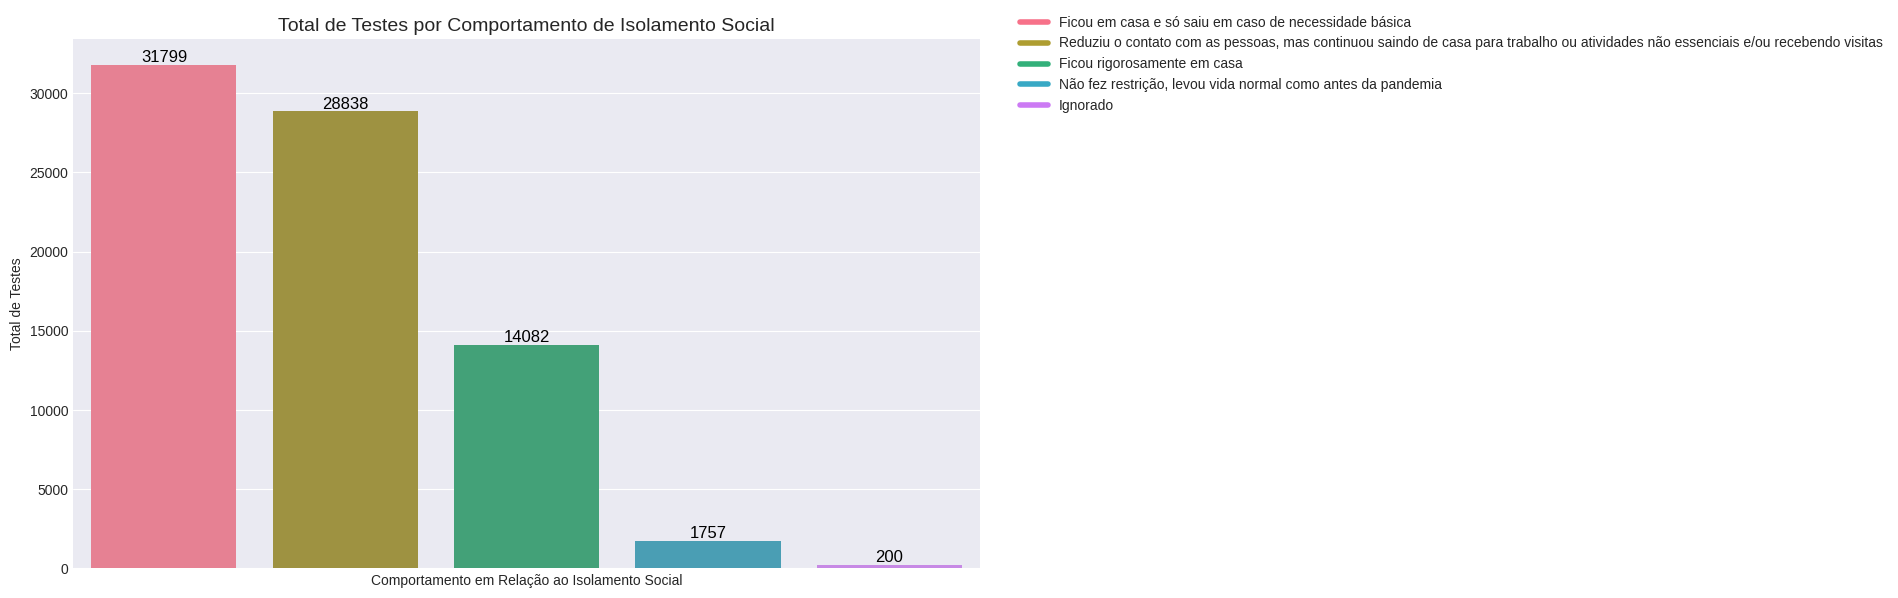

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Contando as ocorrências de cada comportamento de isolamento
contagem_restricao = df_urbano_pandas['restricao_contato'].value_counts().reset_index()
contagem_restricao.columns = ['Comportamento', 'Total']

# Ordenando os valores da maior para a menor
contagem_restricao = contagem_restricao.sort_values(by='Total', ascending=False)

# Criando o gráfico
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(contagem_restricao))  # Paleta de cores distinta

# Gráfico de barras vertical
bar_plot = sns.barplot(x='Comportamento', y='Total', data=contagem_restricao, palette=colors)

# Adicionando os valores em cima das barras
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}',
                      (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha='center', va='bottom', fontsize=12, color='black')

plt.title('Total de Testes por Comportamento de Isolamento Social', fontsize=14)
plt.ylabel('Total de Testes')
plt.xlabel('Comportamento em Relação ao Isolamento Social')
plt.xticks([])  # Remove os nomes das barras do eixo x
plt.tight_layout()

# Adicionando a legenda à direita do gráfico com mais espaço
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
labels = contagem_restricao['Comportamento'].tolist()
plt.figlegend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.9, 1))

# Exibindo o gráfico
plt.show()


<ipython-input-64-828b5999a6d3>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Método de Coleta', y='Proporção de Testes Positivos (%)', data=df_testes, palette='Reds_d')


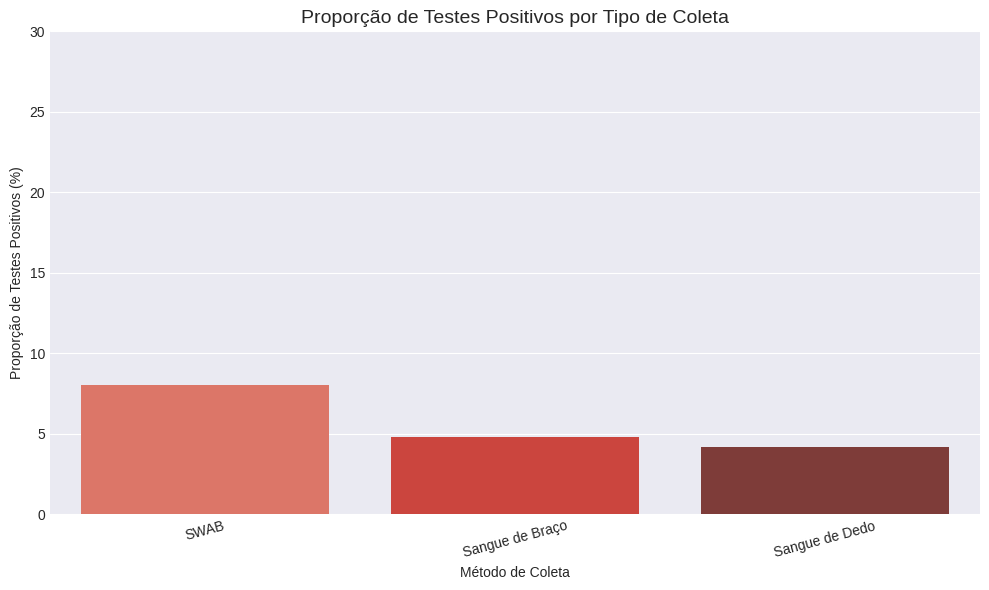

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agrupando e calculando a proporção de positivos por tipo de coleta
df_testes_coleta = df_urbano_pandas[['exame_swab', 'resultado_swab', 'exame_sangue_dedo', 'resultado_sangue_dedo', 'exame_sangue_braco', 'resultado_sangue_braco']]

# Contando resultados positivos e totais por cada tipo de teste
total_swab = df_testes_coleta['exame_swab'].notnull().sum()
positivos_swab = df_testes_coleta[df_testes_coleta['resultado_swab'] == 'Positivo'].shape[0]

total_sangue_dedo = df_testes_coleta['exame_sangue_dedo'].notnull().sum()
positivos_sangue_dedo = df_testes_coleta[df_testes_coleta['resultado_sangue_dedo'] == 'Positivo'].shape[0]

total_sangue_braco = df_testes_coleta['exame_sangue_braco'].notnull().sum()
positivos_sangue_braco = df_testes_coleta[df_testes_coleta['resultado_sangue_braco'] == 'Positivo'].shape[0]

# Calculando a proporção em porcentagem
proporcao_swab = (positivos_swab / total_swab * 100) if total_swab > 0 else 0
proporcao_sangue_dedo = (positivos_sangue_dedo / total_sangue_dedo * 100) if total_sangue_dedo > 0 else 0
proporcao_sangue_braco = (positivos_sangue_braco / total_sangue_braco * 100) if total_sangue_braco > 0 else 0

# Criando um DataFrame para o gráfico
data_testes = {
    'Método de Coleta': ['SWAB', 'Sangue de Dedo', 'Sangue de Braço'],
    'Proporção de Testes Positivos (%)': [proporcao_swab, proporcao_sangue_dedo, proporcao_sangue_braco]
}
df_testes = pd.DataFrame(data_testes)

# Ordenando do maior para o menor
df_testes = df_testes.sort_values(by='Proporção de Testes Positivos (%)', ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Método de Coleta', y='Proporção de Testes Positivos (%)', data=df_testes, palette='Reds_d')

plt.title('Proporção de Testes Positivos por Tipo de Coleta', fontsize=14)
plt.ylabel('Proporção de Testes Positivos (%)')
plt.xlabel('Método de Coleta')
plt.ylim(0, 30)  # Ajustando o limite do eixo y
plt.xticks(rotation=15)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

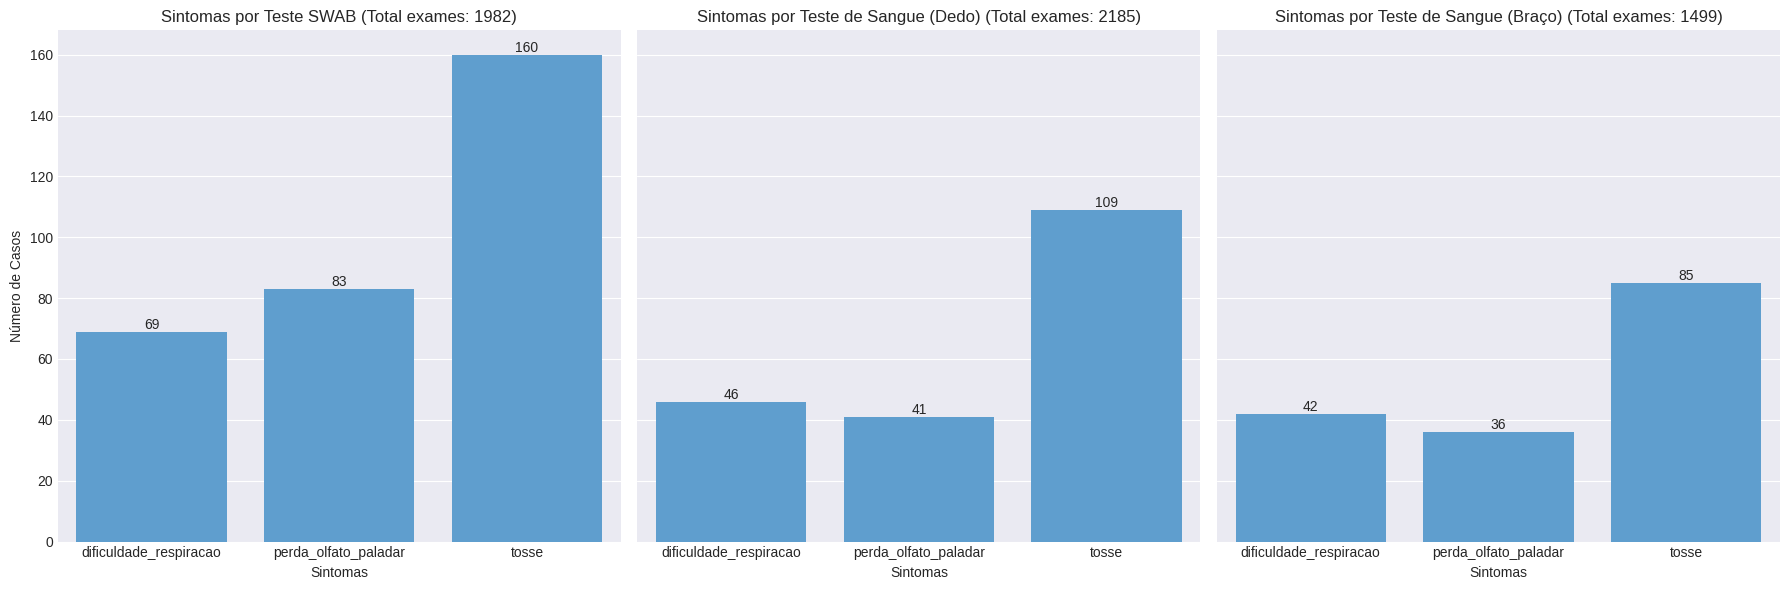

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem de sintomas por método de teste
sintomas_swab = df_urbano_pandas[df_urbano_pandas['exame_swab'] == 'Sim'][['dificuldade_respiracao', 'perda_olfato_paladar', 'tosse']].apply(pd.Series.value_counts).fillna(0)
sintomas_dedo = df_urbano_pandas[df_urbano_pandas['exame_sangue_dedo'] == 'Sim'][['dificuldade_respiracao', 'perda_olfato_paladar', 'tosse']].apply(pd.Series.value_counts).fillna(0)
sintomas_braco = df_urbano_pandas[df_urbano_pandas['exame_sangue_braco'] == 'Sim'][['dificuldade_respiracao', 'perda_olfato_paladar', 'tosse']].apply(pd.Series.value_counts).fillna(0)

# Preparando os dados para os gráficos
sintomas_swab = sintomas_swab.loc['Sim']
sintomas_dedo = sintomas_dedo.loc['Sim']
sintomas_braco = sintomas_braco.loc['Sim']

# Contando o total de respostas 'Sim' para cada teste
total_swab = df_urbano_pandas['exame_swab'].value_counts().get('Sim', 0)
total_dedo = df_urbano_pandas['exame_sangue_dedo'].value_counts().get('Sim', 0)
total_braco = df_urbano_pandas['exame_sangue_braco'].value_counts().get('Sim', 0)

# Criando o gráfico
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Gráfico para SWAB
sns.barplot(x=sintomas_swab.index, y=sintomas_swab.values, ax=ax[0], color='#4CA1E0')
ax[0].set_title(f'Sintomas por Teste SWAB (Total exames: {total_swab})')
ax[0].set_xlabel('Sintomas')
ax[0].set_ylabel('Número de Casos')
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom')

# Gráfico para Sangue de Dedo
sns.barplot(x=sintomas_dedo.index, y=sintomas_dedo.values, ax=ax[1], color='#4CA1E0')
ax[1].set_title(f'Sintomas por Teste de Sangue (Dedo) (Total exames: {total_dedo})')
ax[1].set_xlabel('Sintomas')
for p in ax[1].patches:
    ax[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom')

# Gráfico para Sangue de Braço
sns.barplot(x=sintomas_braco.index, y=sintomas_braco.values, ax=ax[2], color='#4CA1E0')
ax[2].set_title(f'Sintomas por Teste de Sangue (Braço) (Total exames: {total_braco})')
ax[2].set_xlabel('Sintomas')
for p in ax[2].patches:
    ax[2].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

<ipython-input-83-26ea7e6af390>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Método de Coleta', y='Proporção de Internações (%)', data=df_internacoes, palette='Purples_d')


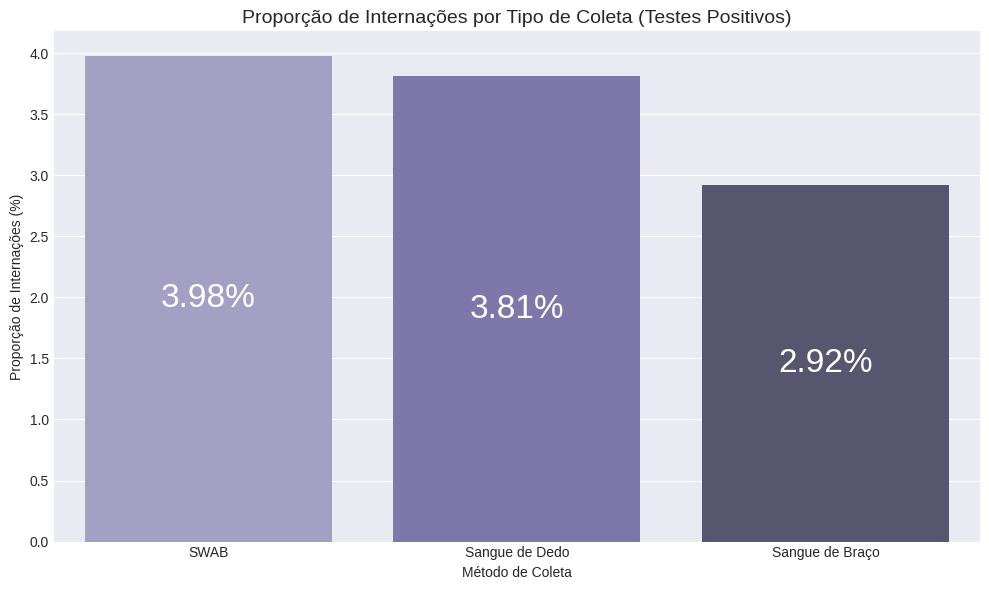

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contando internações por tipo de teste positivo
internacoes_swab = df_urbano_pandas[(df_urbano_pandas['resultado_swab'] == 'Positivo') & (df_urbano_pandas['internação'] == 'Sim')].shape[0]
internacoes_sangue_dedo = df_urbano_pandas[(df_urbano_pandas['resultado_sangue_dedo'] == 'Positivo') & (df_urbano_pandas['internação'] == 'Sim')].shape[0]
internacoes_sangue_braco = df_urbano_pandas[(df_urbano_pandas['resultado_sangue_braco'] == 'Positivo') & (df_urbano_pandas['internação'] == 'Sim')].shape[0]

# Contando o total de resultados positivos para cada tipo de teste
total_swab = df_urbano_pandas['resultado_swab'].value_counts().get('Positivo', 0)
total_dedo = df_urbano_pandas['resultado_sangue_dedo'].value_counts().get('Positivo', 0)
total_braco = df_urbano_pandas['resultado_sangue_braco'].value_counts().get('Positivo', 0)

# Calculando a proporção de internações
proporcao_internacoes = [
    (internacoes_swab / total_swab * 100) if total_swab > 0 else 0,
    (internacoes_sangue_dedo / total_dedo * 100) if total_dedo > 0 else 0,
    (internacoes_sangue_braco / total_braco * 100) if total_braco > 0 else 0
]

# Criando o dataframe para o gráfico
data_internacoes = {
    'Método de Coleta': ['SWAB', 'Sangue de Dedo', 'Sangue de Braço'],
    'Proporção de Internações (%)': proporcao_internacoes
}

df_internacoes = pd.DataFrame(data_internacoes)

# Criando o gráfico de barras
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Método de Coleta', y='Proporção de Internações (%)', data=df_internacoes, palette='Purples_d')

plt.title('Proporção de Internações por Tipo de Coleta (Testes Positivos)', fontsize=14)
plt.ylabel('Proporção de Internações (%)')
plt.xlabel('Método de Coleta')

# Exibindo os números dentro das barras
for index, value in enumerate(proporcao_internacoes):
    bars.text(index, value / 2, f'{value:.2f}%', ha='center', va='center', fontsize=24, color='white')

plt.tight_layout()
plt.show()

<Figure size 2000x800 with 0 Axes>

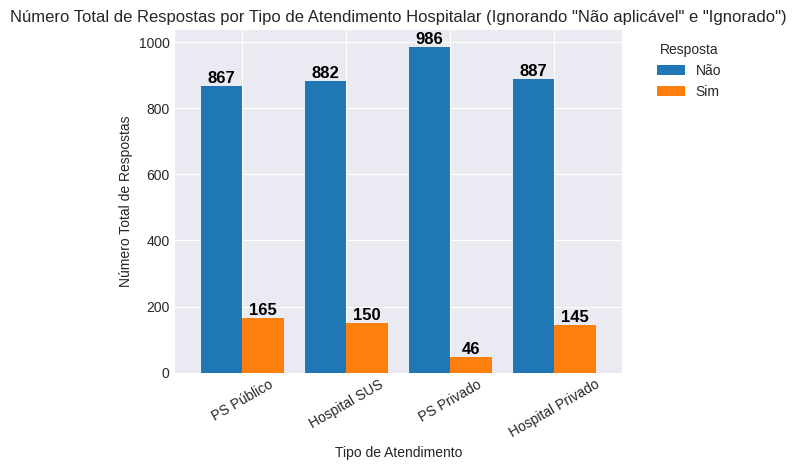

In [ ]:
# Filtrar as colunas relevantes e remover as respostas 'Não aplicável' e 'Ignorado'
filtered_df = df_urbano_pandas[
    (df_urbano_pandas['pronto_socorro_pub'] != 'Não aplicável') &
    (df_urbano_pandas['hospital_sus'] != 'Não aplicável') &
    (df_urbano_pandas['pronto_socorro_priv'] != 'Não aplicável') &
    (df_urbano_pandas['hospital_privado'] != 'Não aplicável') &
    (df_urbano_pandas['pronto_socorro_pub'] != 'Ignorado') &
    (df_urbano_pandas['hospital_sus'] != 'Ignorado') &
    (df_urbano_pandas['pronto_socorro_priv'] != 'Ignorado') &
    (df_urbano_pandas['hospital_privado'] != 'Ignorado')
]

# Contar o número total de respostas para cada categoria
total_respostas = filtered_df[['pronto_socorro_pub', 'hospital_sus', 'pronto_socorro_priv', 'hospital_privado']].apply(pd.Series.value_counts).fillna(0)

# Transpor o DataFrame para facilitar a plotagem
total_respostas = total_respostas.T

# Criar um dicionário de aliases
aliases = {
    'pronto_socorro_pub': 'PS Público',
    'hospital_sus': 'Hospital SUS',
    'pronto_socorro_priv': 'PS Privado',
    'hospital_privado': 'Hospital Privado'
}

# Renomear os índices usando os aliases
total_respostas.index = [aliases[col] for col in total_respostas.index]

# Criar um gráfico de barras agrupadas
plt.figure(figsize=(20, 8))  # Aumenta o tamanho do gráfico para ser mais largo
ax = total_respostas.plot(kind='bar', width=0.8)

# Adicionar os valores acima de cada barra com cor preta
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', weight='bold')

# Personalizar o gráfico
plt.title('Número Total de Respostas por Tipo de Atendimento Hospitalar (Ignorando "Não aplicável" e "Ignorado")')
plt.xlabel('Tipo de Atendimento')
plt.ylabel('Número Total de Respostas')
plt.xticks(rotation=30)
plt.legend(title='Resposta', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)  # Reposiciona a legenda
plt.tight_layout()

# Exibir o gráfico
plt.show()
